# Кластеризация k-средних
##  Импорт

In [1]:
import numpy as np # библиотека Numpy для операций линейной алгебры и прочего
import pandas as pd # Библиотека Pandas для работы с табличными данными
import matplotlib.pyplot as plt # библиотека Matplotlib для визуализации
from matplotlib.colors import ListedColormap # функция библиотеки Matplotlib, которая генерирует цветовую карту

from sklearn.datasets import make_moons, make_circles, make_classification # генерируемые наборы данных 
pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 20)
pd.set_option("display.precision", 6)
pd.set_option("plotting.backend", "matplotlib")
%matplotlib inline

plt.style.use('default')

## Методы

In [2]:
class KMeans():
    def __init__(self,n_clusters = 2, centroids = None,
                 max_iter=10, tol=0.01,
                 metric = 'euclidean', p = 2,
                 random_state = None):
        self.n_clusters = n_clusters
        self.centroids  = centroids
        self.max_iter   = max_iter
        self.tol        = tol
        self.iters      = None
        self.inertia = None
        self.metric = metric
        self.p  = p
        self.random_state  = random_state


    def distance(self,X1, X2):
        """
        оценка расстояния
        """

        if self.metric == 'euclidean':
            dist = np.sqrt(np.sum(np.square(X1 - X2).T,axis=0))
        if self.metric == 'cityblock':
            dist = np.sum(np.abs(X1 - X2).T,axis=0)
        if self.metric == 'Chebyshev':
            dist = np.max(np.abs(X1 - X2).T,axis=0)
        if self.metric == 'Minkowski':
            dist = np.power(np.sum(np.power(np.abs(X1 - X2),self.p).T,axis=0),1/self.p)
        return dist


    def init_centroids(self, X):
        """
        инициализация первых центров кластеров
        """

        if self.random_state: rng = np.random.seed(self.random_state)
        c_idxs = np.random.randint(0, X.shape[0], size = self.n_clusters)
        return X[c_idxs,:]


    def predict(self, X):
        """
        оценка пренадлежности точек к кластеру по расстоянию
        """

        distances = np.zeros((X.shape[0], self.n_clusters))

        for i,centr in enumerate(self.centroids):
            distances[:,i] = self.distance(centr,X)
        self.inertia = np.sum(np.power(np.min(distances,axis = 1),2))
        return np.argmin(distances,axis = 1)


    def transform(self,X):
        # получение предсказаний
        return self.predict(X)


    def delta_centroids(self,old_centroids):
        """
        оценка относительного изменения центров кластеров.
        относительное расстояние между старыми и новыми центроидами
        """

        return (
                self.distance(self.centroids,old_centroids)/
                self.distance(old_centroids, np.mean(old_centroids))
               ).mean()


    def fit(self, X):
        """
        Итерационная кластеризация.
        обучение - несколько итераций алгоритма к-Средних
        """

        if self.centroids is None: # если центры кластеров не заданы - задаем
            self.centroids = self.init_centroids(X)

        d_centrs = np.inf

        for i in range(self.max_iter):

            old_centroids = np.copy(self.centroids)

            cluster_label = self.predict(X)

            for k in range(self.n_clusters):

                c_idxs = np.flatnonzero(cluster_label==k)

                self.centroids[k] = X[c_idxs].mean(axis = 0)

            d_centrs = self.delta_centroids(old_centroids)

            self.iters = i
            if d_centrs<=self.tol:
                break
        return self


    def fit_transform(self, X):
        """
         и обучаем и сразу выдаем метки кластеров
        """

        return self.fit(X).predict(X)

In [3]:
def plot_data(ax,ds,name='',marker = 'o',colors =("#FF0000", '#0000FF'),alpha=0.7, s = 150, facecolor=True):
    """Визуализация двумерных  данных для классификации   
    Входные переменные:
    ===========
    ax: отдельная ячейка объекта figure
    ds: набор данных, содержащий признаки X и целевые метки y
    name: название графика
    marker: тип маркера - по умолчанию просто круги
    colors: цвета, которые будут использоваться для раскраски разных классов - по умолчанию Красный и Синий
    alpha: прозрачность маркеров
    s: размер маркера (~ квадрат радиуса)
    facecolor:
    """
    
    X, y = ds # распаковываем признаки и целевые метки в отдельные переменные

    cm_bright = ListedColormap(colors) # формируем цветовую карту из наших цветов
    ax.set_title(name, fontsize = 30) # прописываем название графика
    if facecolor: # если переменная задана - то просто рисуем скатерограмму по признакам с использованием параметров маркеров
        ax.scatter(X[:, 0], X[:, 1],
                   marker = marker, c=y,
                   cmap=cm_bright,s = s,
                   alpha =alpha)
    else: # иначе так же рисуем скатерограмму, но без
        ax.scatter(X[:, 0], X[:, 1],
                   marker = marker, c=y,
                   cmap=cm_bright,s = s,
                   facecolor = 'None',
                   alpha =alpha)
    # немного красоты и ля аккуратности
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5 # фиксируем минимальные и максимальные значения по горизонтали
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5 # фиксируем минимальные и максимальные значения по вертикали
    ax.grid(True)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

In [4]:
def make_binary_clf(N, method = 'line',
                    noises = 0.15,
                    random_state = 42):
    """Создание синтетического набора данных
    для бинарной классификации
    Входные переменные:
    ===========
    N: количество точек
    method: тип набора данных
    noises: коэффициент ~ сила шума
    random_state: фиксированный сид случайных чисел (для повторяемости)
    """
    # фиксируем случайный seed
    if random_state: rng = np.random.RandomState(seed = random_state)

    if method == 'line' or method is None:
        # если выбран метод line (или никакой не задан)
        # то мы создаем набор данных с использованием функции make_classification
        # это будут линейно-разделимые данные
        X, y = make_classification(n_samples=N, # количество точек
                                   n_features=2, # количество признаков
                                   n_redundant=0, # количество бесполезных признаков
                                   n_informative=2,# количество информативных признаков
                                   n_clusters_per_class=1, # количество групп точек на класс
                                   class_sep=2, # количество классов
                                   random_state=random_state # фиксированный сид случайных чисел
                                   )
        X += np.random.randn(*X.shape) *noises # добавляем к признакам случайный шум

    elif method == 'moons':
        # если выбран метод moons
        # то мы создаем набор данных с использованием функции make_moons
        # это будут данные похожие на Инь-Ян
        X, y = make_moons(n_samples=N, # количество точек
                          noise=noises, # уровень шума
                          random_state=random_state # фиксированный сид случайных чисел
                          )

    elif method == 'circles':
        # если выбран метод circles
        # то мы создаем набор данных с использованием функции make_circles
        # это будут данные в виде концентрических окружностей
        X, y = make_circles(n_samples=N, # количество точек
                            noise=noises, # уровень шума
                            factor=0.5, # соотношение радиусов внуренней и внешней окружности
                            random_state=random_state # фиксированный сид случайных чисел
                            )


    return X,y

In [5]:
def plot_cluster(X,centroids, cluster_label, centroids_label, old_centroids = None, old_centroids_label = None):
    """Визуализация кластера
    Входные переменные:
    ===========
    X: признаки
    centroids: текущие центры кластеров
    cluster_label: метки кластеров для признаков
    centroids_label: метки для текущих центров кластеров
    old_centroids: предыдущие центры кластеров
    old_centroids_label: метки для предыдущих центров кластеров
    """
    fig = plt.figure(figsize=(11,10)) # Создаем полотно
    # Визуализируем наши признаки
    plt.scatter(X[:, 0], X[:, 1],
                c = cluster_label, cmap = 'bwr',
                s=100,alpha = 0.6)
    # Визуализируем текущие центры кластеров. Как точки, но побольше
    plt.scatter(centroids[:, 0], centroids[:, 1],
                c = centroids_label, cmap = 'bwr',
                s=400, edgecolors = 'k')

    if old_centroids is not None: # если хотим визуализировать предыдущие центры кластеров
        # их отрисуем поменьше, чем текущие центры, но больше чем "рядовые точки"
        plt.scatter(old_centroids[:, 0], old_centroids[:, 1],
            c = old_centroids_label, cmap = 'bwr',
            s=200, edgecolors = 'k')

    plt.xticks([])
    plt.yticks([])

## Кластеризация k-средних для синтетических данных

### Данные

In [6]:
N = 150
moons_data = make_binary_clf(N, method='moons', noises=0.1)
X,y = moons_data
X.shape

(150, 2)

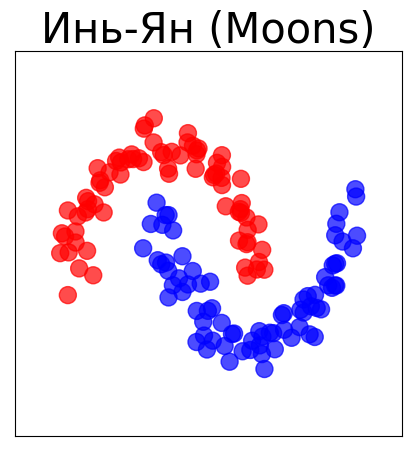

In [7]:
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)
plot_data(ax, moons_data, 'Инь-Ян (Moons)')
plt.show()

### Выбор оптимального числа кластеров
Будем использовать метод локтя для оценки оптимального числа кластеров

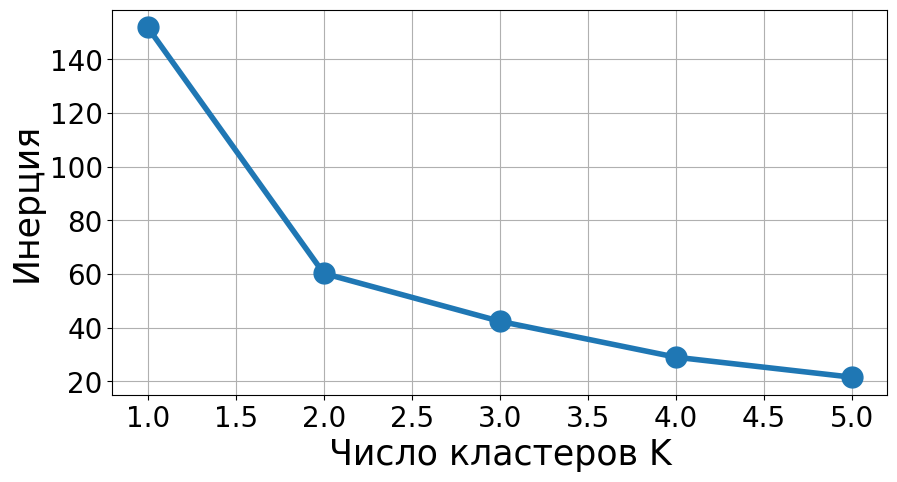

In [8]:
sse = [] # здесь будем хранить инерции для конкретных к
list_k = list(range(1, 6))
for k in list_k: # тестируем различные к в диапазоне от 1 до 5
    km = KMeans(n_clusters=k)# создаем объект кластеризации с заданным к
    km.fit(X) # обучаем
    sse.append(km.inertia) # фиксируем текущую инерцию

# визуализируем метод локтя. ниже используется много раз встречающаяся визуализация
plt.figure(figsize=(10, 5))
plt.plot(list_k, sse, '-o',
         linewidth = 4, markersize = 15)
plt.xlabel('Число кластеров K', fontsize = 25)
plt.ylabel('Инерция', fontsize = 25)

plt.grid();
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20);

На локоть больше похоже значение 2. Будем использовать это значение.

Мы остановились на итерации:: 4


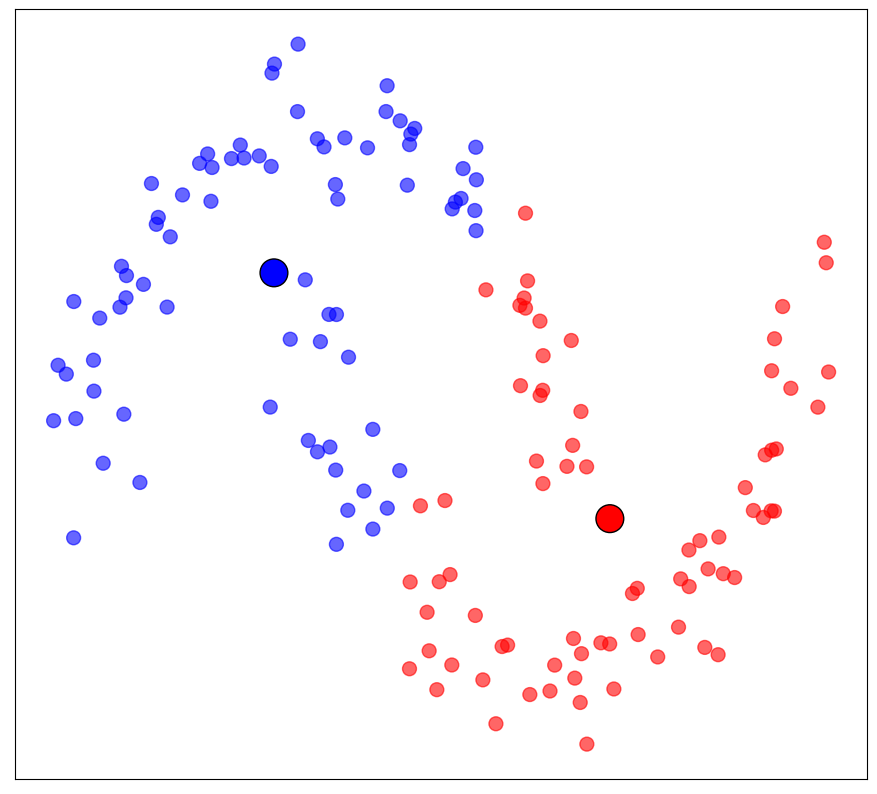

In [9]:
# Создаем модель-объект
kmeans   = KMeans(n_clusters=2,max_iter=1000, tol=0.01, random_state= 42, metric='Minkowski') # создаем объект

# Обучаем  и извлекаем метки кластеров через `.fit_transform()`
c_labels = kmeans.fit_transform(X) # обучаем и сразу складываем метки кластеров
print('Мы остановились на итерации::',kmeans.iters)

# визуализируем
plot_cluster(X,kmeans.centroids,
             c_labels, np.unique(c_labels),)

Кластеризация выполнена неточно. Посмотрим для 4 кластеров

Мы остановились на итерации:: 8


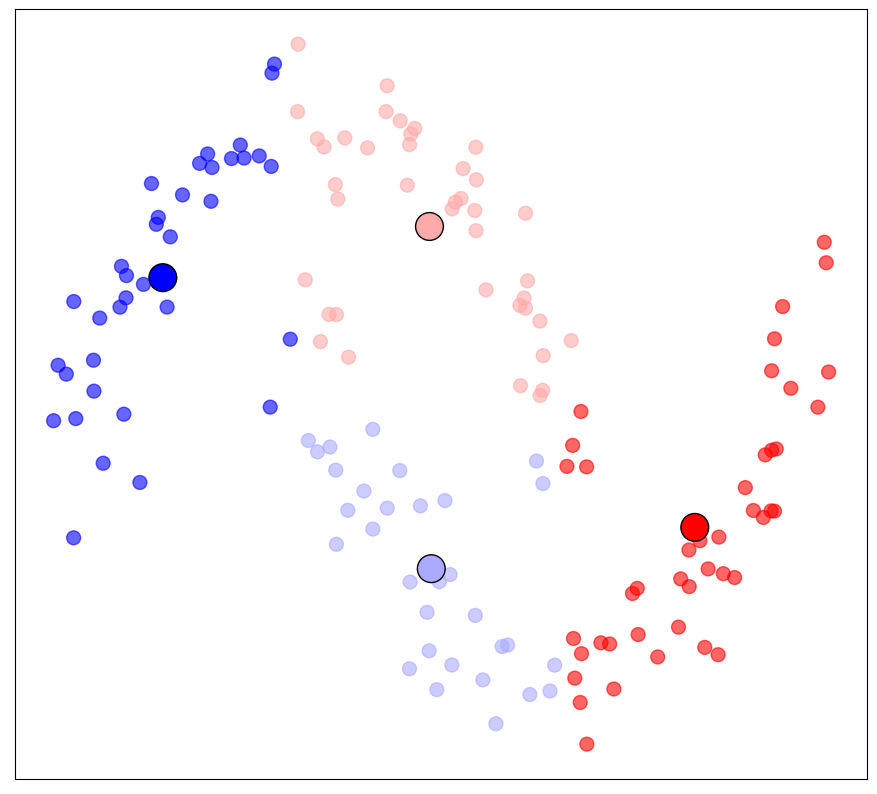

In [10]:
kmeans2   = KMeans(n_clusters=4,max_iter=100, tol=0.01, random_state= 42)
c_labels2 = kmeans2.fit_transform(X)
print('Мы остановились на итерации::',kmeans2.iters)

plot_cluster(X,kmeans2.centroids,
             c_labels2, np.unique(c_labels2),)

Теперь результаты ближе к истине, за исключением того, что к одной категории относятся по 2 кластера.

Связь кластеров с категориальными признаками

In [11]:
pd.crosstab(y,c_labels, rownames=['Метки'], colnames = ['Предсказания'])

Предсказания,0,1
Метки,,
0,57,18
1,18,57


По этой таблице видно, что 0-й кластер наиболее связан с 0-ой меткой, а 1-й кластер - с 1-й меткой.


## Кластеризация k-средних для набора данных MNIST

### Загрузка  данных

In [12]:
df = pd.read_csv('./content/pca_result_mnist.csv', delimiter = ',')


### Кластеризация

#### Число кластеров - 10

Мы остановились на итерации:: 14


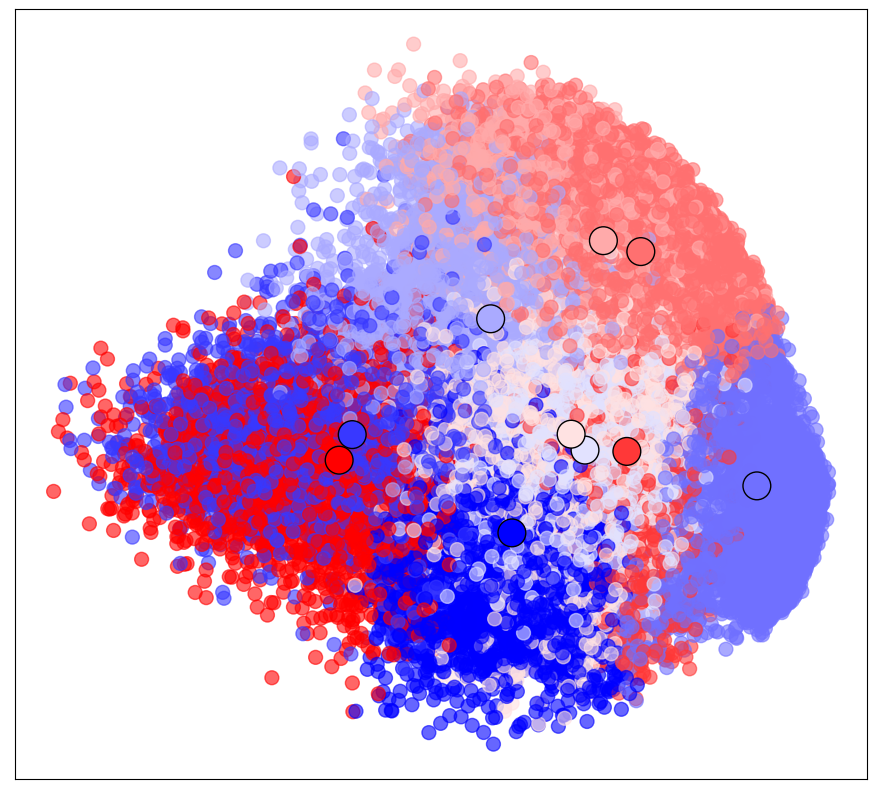

In [13]:
X_3=df.iloc[:,0:4].values
kmeans3   = KMeans(n_clusters=10,max_iter=1000, tol=0.01, random_state= 42)
c_labels3 = kmeans3.fit_transform(X_3)
print('Мы остановились на итерации::',kmeans3.iters)

plot_cluster(X_3,kmeans3.centroids,
             c_labels3, np.unique(c_labels3),)


#### Число кластеров - 4

Мы остановились на итерации:: 13


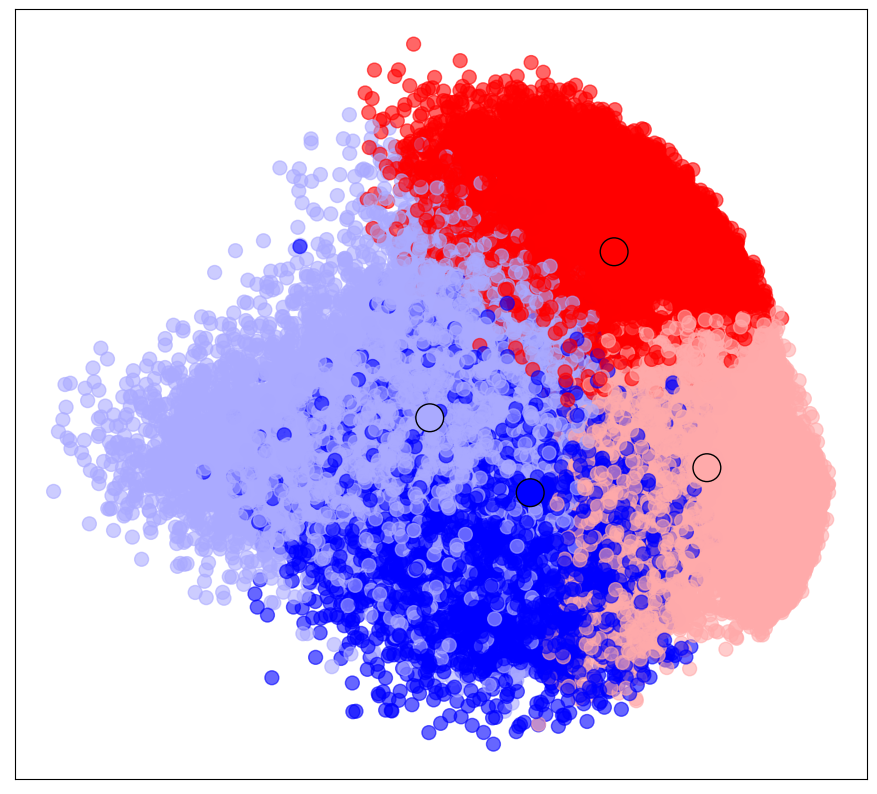

In [14]:
X_3=df.iloc[:,0:4].values
kmeans3   = KMeans(n_clusters=4,max_iter=1000, tol=0.01, random_state= 42)
c_labels3 = kmeans3.fit_transform(X_3)
print('Мы остановились на итерации::',kmeans3.iters)

plot_cluster(X_3,kmeans3.centroids,
             c_labels3, np.unique(c_labels3),)
